In [0]:
'''
Useful doc:
- https://arxiv.org/pdf/1511.06434.pdf
- https://keras.io/layers/
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
'''

# Native libs
import os
import time
import logging
import glob

# Added libs
import tensorflow as tf # Machine learning lib
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Make results folder in Colab to save images to
if not os.path.exists("results"):
  os.mkdir('results')

In [0]:
# --------------
# Data processing
# --------------

def cast_and_normalize(images):
    # Cast the images to float32 (pixels)
    # images.shape[0] is the number of images
    images = images.reshape(images.shape[0], 28, 28, 3).astype('float32')
    # Normalize the images between -1 and 1 from [0, 255] (pixels)
    images = (images - 127.5) / 127.5
    return images

def to_dataset(images, buffer_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    # Creates a chunk
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset

In [0]:
def load_fruit_data():
  keras = tf.keras.preprocessing.image
  IMG_DIM = (28, 28)
  apples = '/content/drive/My Drive/CSE_142/fruits/apples/**/*.jpg'
  apples = glob.glob(apples)
  other_fruits = '/content/drive/My Drive/CSE_142/fruits/other_fruits/**/*.jpg'
  other_fruits = glob.glob(other_fruits)
  
  # fruits = apples + other_fruits
  fruits = apples
  # fruits = other_fruits
  # size = len(fruits)
  size = 10
 
  train_images = []
  for i in range(0, size):
    image = keras.load_img(fruits[i], target_size=IMG_DIM, color_mode="rgb")
    image = np.asarray(image)
    train_images.append(image)
  
  train_images = np.asarray(train_images)
  return train_images

In [0]:
# --------------
# File & image management
# --------------

def generate_and_save_images(model, epoch, test_input):
    # Training is set to False so all layers run in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        image = predictions[i, :, :, :] * 127.5 + 127.5
        image = tf.cast(image, tf.int64)
        plt.imshow(image)
        plt.axis('off')

    plt.savefig('results/image_at_epoch_{:03d}.png'.format(epoch))
    # plt.show()

In [0]:
# --------------
# Plotting loss
# --------------

def plot_loss(epoch_list, gen_loss_list, disc_loss_list):
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. Epochs')
  plt.plot(epoch_list, gen_loss_list, 'c', label = "Generator Loss")
  plt.plot(epoch_list, disc_loss_list, 'm', label = "Discriminator Loss")
  plt.show()

In [0]:
# --------------
# Plotting output
# --------------

def plot_output(epoch_list, real_output_list, fake_output_list):
  plt.xlabel('Epochs')
  plt.ylabel('Output')
  plt.title('Output vs. Epochs')
  plt.plot(epoch_list, real_output_list, 'c', label = "Real Output")
  plt.plot(epoch_list, fake_output_list, 'm', label = "Fake Output")
  plt.show()

In [0]:
# --------------
# Models
# --------------

def generator_model():
    """
    This model is based on this paper: https://arxiv.org/pdf/1511.06434.pdf
    """

    # This is a bit complicated. I'll try to explain it as munch as I can. Make
    # sure to take a look at the figure 1 in the paper to understand what I'm
    # going to say

    # The generator model is a neural network (NN). We will use keras to build
    # a NN.

    # It creates a linear stack of layers. Then we'll be able to add "layers".
    model = tf.keras.Sequential()

    # Let's build the first layer. The input layer.
    # The dense layer is the regular NN layer. output = activation(input dot weigth + bias)
    # 256*7*7: In the paper, they wanted to create a 64x64 pixel image. So they
    # started with 1024x4x4, so it goes to 512x8x8 -> 256x16x16 -> 128x32x32 ->
    # 64x64x3. While always using stride=2. We want the generator to create a
    # 28x28 image. So we will start at 256x7x7 so that it goes to 128x7x7 (with
    # a stride of 1) -> 64x14x14 -> 64x28x28. The stride is the steps of the
    # convolution along the height and the width.
    # bias=False: We don't want the generator to use bias in its calculations
    # input_shape: According to the paper, we need to give a 100x1 noise vector
    model.add(tf.keras.layers.Dense(256*7*7, use_bias=False, input_shape=(100,), activation='relu'))

    # This layer uses batch normalization and ReLu activation
    # It is needed to help with the flow of gradients during training. It is a
    # critical contribution of the DCGAN paper
    model.add(tf.keras.layers.BatchNormalization())

    # We need to reshape because the shape of the data will be (-, 4, 4, 1024)
    # That's because we gave a specific input_shape of (100,)
    model.add(tf.keras.layers.Reshape((7, 7, 256)))

    # 128: It is the dimensionality of the output space
    # (5, 5): It specifies the height and the width of the 2D convolution window
    # (1, 1): It specifies the steps (x, y) of the convolution along the height
    #           and width.
    # 'same': We keep the same padding. The padding can be specified by
    #           output_padding, but we don't need it.
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    # Same explanations as before
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    # Output layer
    # Basically the same thing, but with a different activation. The output of
    # the generator is fed through a tanh function to return it to the input
    # data range of [−1, 1]
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def discriminator_model():
    # See the comments in generator_model to understand the concepts
    model = tf.keras.Sequential()

    # This will be used to specify an activation without having to create an extra
    # activation layer just for this purpose
    lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.3)

    # 64x28x28
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation=lrelu, input_shape=[28, 28, 3]))
    # Dropout consists in randomly setting a fraction rate of input units to 0
    # at each update during training time, which helps prevent overfitting.
    model.add(tf.keras.layers.Dropout(0.3))

    # 128x14x14
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=lrelu))
    model.add(tf.keras.layers.Dropout(0.3))

    # 256x7x7 TODO: needed?
    # model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation=lrelu))
    # model.add(tf.keras.layers.Dropout(0.3))

    # Flattens the input. Does not affect the batch size. If inputs are shaped
    # (batch,) without a channel dimension, then flattening adds an extra
    # channel dimension and output shapes are (batch, 1).
    # 256x1x1
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [0]:
# --------------
# Loss functions
# --------------

def discriminator_loss(loss_func, real_output, fake_output):
    real_loss = loss_func(tf.ones_like(real_output), real_output)
    fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(loss_func, fake_output):
    return loss_func(tf.ones_like(fake_output), fake_output)

In [0]:
# --------------
# Training
# --------------

# @tf.function
def train(image,
          buffer_size, noise_dim,
          generator, discriminator,
          gen_opt, dis_opt,
          loss_func):
    noise = tf.random.normal([buffer_size, noise_dim])

    # For some reason it crashes when GradientTape does not take the whole code
    # block below, whereas it is only used to generate the gradient at the end
    with tf.GradientTape() as gradient_tape1, tf.GradientTape() as gradient_tape2:
      # Generate an image
      generated_image = generator(noise, training=True)

      # Train the discriminator on the real images and on the generated images
      real_output = discriminator(image, training=True)
      fake_output = discriminator(generated_image, training=True)

      # We use the same loss function
      gen_loss = generator_loss(loss_func, fake_output)
      disc_loss = discriminator_loss(loss_func, real_output, fake_output)

      # Add loss to list for plot
      generator_loss_list.append(gen_loss)
      discriminator_loss_list.append(disc_loss)

      # Add output to list for plot
      real_output_list.append(tf.math.reduce_mean(real_output))
      fake_output_list.append(tf.math.reduce_mean(fake_output))

      # Optimize the generator and discriminator using the gradient with the loss
      gradients_of_generator = gradient_tape1.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = gradient_tape2.gradient(disc_loss, discriminator.trainable_variables)

      gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      dis_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
# Parameters
BUFFER_SIZE = 1000 # if too big, the GPU may not be good enough. max = 60,000
BATCH_SIZE = 128
EPOCHS = 100
NOISE_DIM = 100 # Based on DCGAN paper
SAMPLES = 4
# We define a specific seed here to show the evolution of the generator
WATCHED_SEED = tf.random.normal([SAMPLES, NOISE_DIM])

In [0]:
# Load data for fruit dataset
train_images = load_fruit_data()

In [0]:
# Turn the data into a tensorflow dataset
train_dataset = to_dataset(cast_and_normalize(train_images), BUFFER_SIZE, BATCH_SIZE)

In [0]:
# Create models
generator = generator_model()
discriminator = discriminator_model()

In [0]:
# Loss function (cross entropy loss)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizer
# Why do we need an optimizer?? The discriminator and the generator
# optimizers are different since we will train two networks, separately.
# The Adam optimization algorithm is an extension of stochastic gradient
# descent. Stochastic gradient descent maintains a single learning rate
# (termed alpha) for all weight updates while the learning rate does not
# change during training. A learning rate is maintained for each network
# weight (parameter) and adapts as learning unfolds
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [0]:
# List of generator loss by epoch for plotting
generator_loss_list = []
discriminator_loss_list = []
real_output_list = []
fake_output_list = []

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


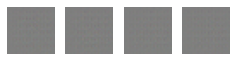

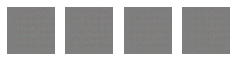

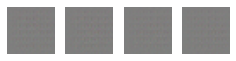

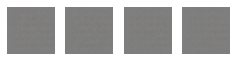

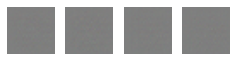

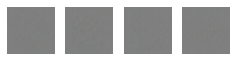

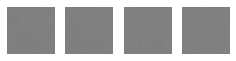

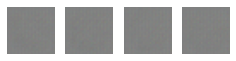

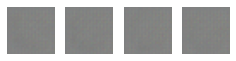

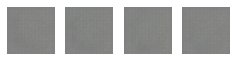

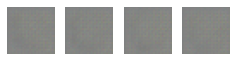

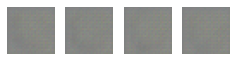

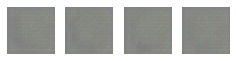

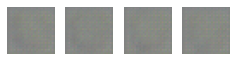

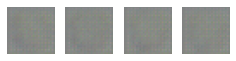

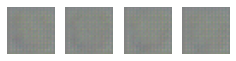

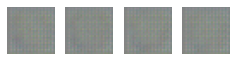

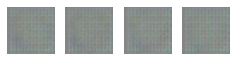

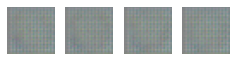

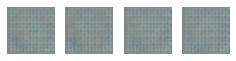

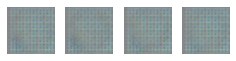

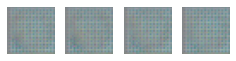

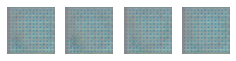

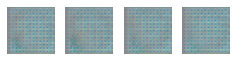

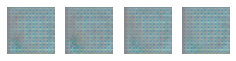

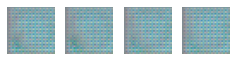

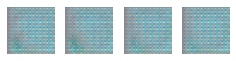

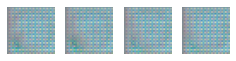

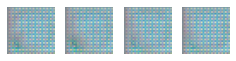

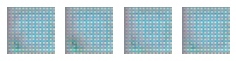

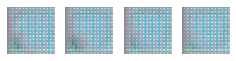

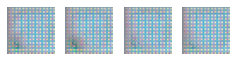

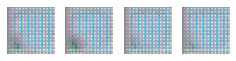

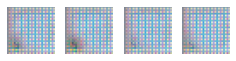

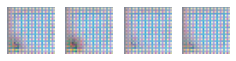

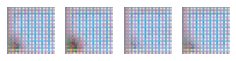

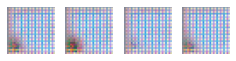

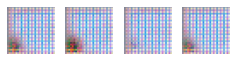

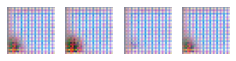

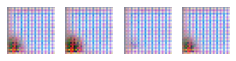

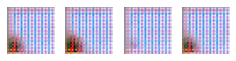

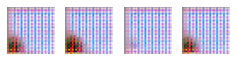

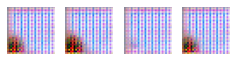

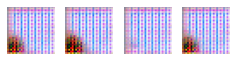

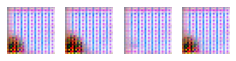

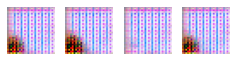

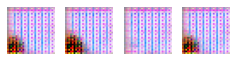

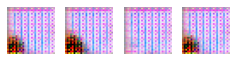

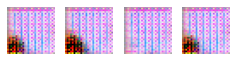

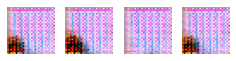

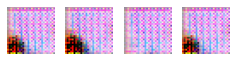

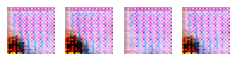

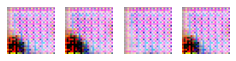

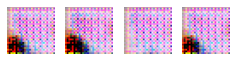

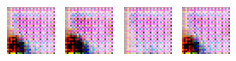

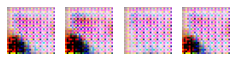

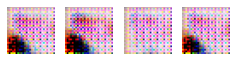

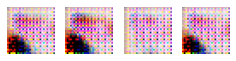

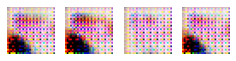

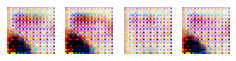

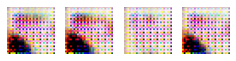

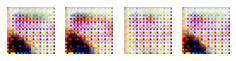

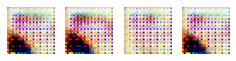

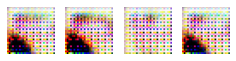

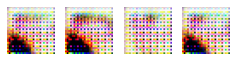

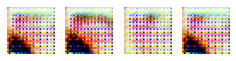

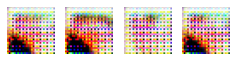

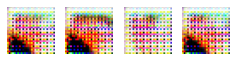

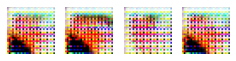

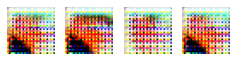

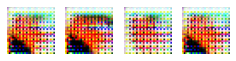

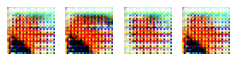

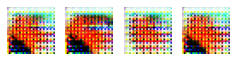

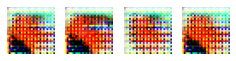

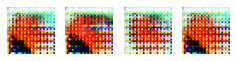

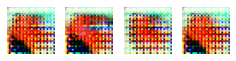

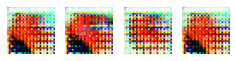

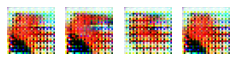

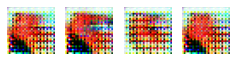

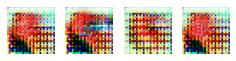

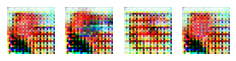

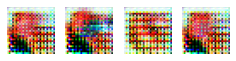

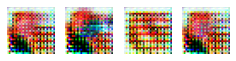

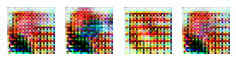

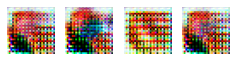

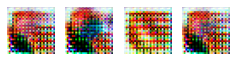

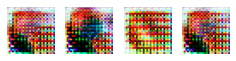

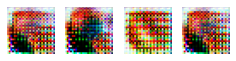

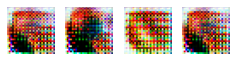

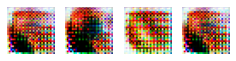

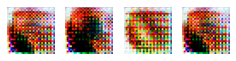

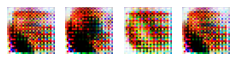

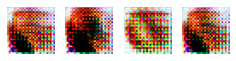

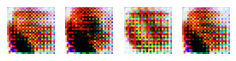

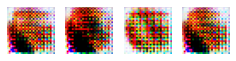

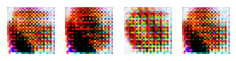

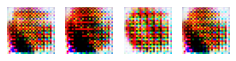

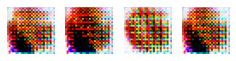

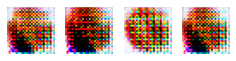

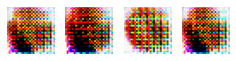

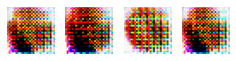

In [41]:
# Train
for epoch in range(EPOCHS):
    start = time.time()

    for image in train_dataset:
        train(
            image,
            BUFFER_SIZE, NOISE_DIM,
            generator, discriminator,
            generator_optimizer, discriminator_optimizer,
            cross_entropy
        )

    generate_and_save_images(generator, epoch + 1, WATCHED_SEED)

# Generate after the final epoch
generate_and_save_images(generator, EPOCHS, WATCHED_SEED)

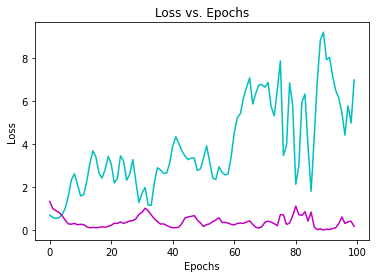

In [47]:
# Plot the loss
epoch_list = list(range(EPOCHS))
plot_loss(epoch_list, generator_loss_list, discriminator_loss_list)

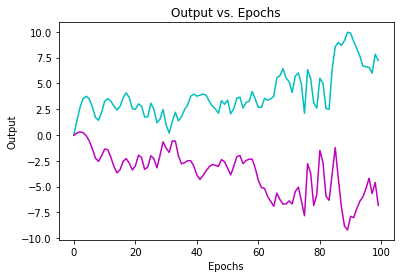

In [50]:
# Plot the output
plot_output(epoch_list, real_output_list, fake_output_list)

In [0]:
# !zip -r results/100_epochs.zip results/